In [338]:
#!g1.1
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-32GB


## Dataset

Датасет русских новостей

In [339]:
#!g1.1
import pandas as pd

In [340]:
#!g1.1

train_df = pd.read_csv('../data/inappropriate/train.csv')
test_df = pd.read_csv('../data/inappropriate/test.csv')

In [405]:
#!g1.1
train_df.shape, test_df.shape

((130665, 21), (16334, 22))

In [342]:
#!g1.1
train_df.head()

,text,inappropriate,offline_crime,online_crime,drugs,gambling,pornography,prostitution,slavery,suicide,...,weapons,body_shaming,health_shaming,politics,racism,religion,sexual_minorities,sexism,social_injustice,human_labeled
0,я думал что левиафаны - это те медленные страх...,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,"А был бы этот полицейский в Петербурге, так пе...",0.95,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,"Напоминаю, что пора искать актис невзрослого п...",1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,курю лет пятнадцать никаких проблем кроме како...,1.00,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,"окей, я тогда проведу парад гетеросексуалов, п...",1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [303]:
#!g1.1

(train_df.inappropriate > 0.5).astype('int').value_counts()

0    91803
1    38862
Name: inappropriate, dtype: int64

In [304]:
#!g1.1

# statistics of text length (in words)
train_df['text'].apply(lambda s: len(s.split())).describe()

count    130665.000000
mean         16.149834
std          11.963462
min           1.000000
25%           9.000000
50%          13.000000
75%          21.000000
max         738.000000
Name: text, dtype: float64

In [36]:
#!g1.1
train_df['text'].apply(lambda s: len(s.split())).quantile(0.99)

42.0



Let's extract the sentences and labels of our training set as numpy ndarrays.

In [367]:
#!g1.1
# Get the lists of sentences and their labels.
sentences = train_df.text.values
labels = (train_df.inappropriate > 0.5).astype('int').values

#valid_df

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. BERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [ ]:
На этот раз, используем русскоязычный Берт от Дип Павлова

In [343]:
#!g1.1
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased', do_lower_case=True)

Loading BERT tokenizer...






In [273]:
#!g1.1

# сравним с мультиязычной моделью
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('Geotrend/bert-base-ru-cased', do_lower_case=True)  #мультиязычная, но только с русским словарем

Loading BERT tokenizer...





Let's apply the tokenizer to one sentence just to see the output.


In [307]:
#!g1.1
# Print the original sentence.
print(' Original: ', sentences[1000])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[1000]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1000])))

 Original:  Я уже написал как я понимаю принцип око за око. Соотносится ли он с заповедями какой либо религии мне все равно. Я не верю ни в одну существующую религию ибо они все лгут и преследуют свои цели)
Tokenized:  ['я', 'уже', 'написал', 'как', 'я', 'понимаю', 'принцип', 'око', 'за', 'око', '.', 'соотносится', 'ли', 'он', 'с', 'заповед', '##ями', 'как', '##ои', 'либо', 'религии', 'мне', 'все', 'равно', '.', 'я', 'не', 'верю', 'ни', 'в', 'одну', 'существующую', 'религию', 'ибо', 'они', 'все', 'л', '##гут', 'и', 'преследуют', 'свои', 'цели', ')']
Token IDs:  [877, 4745, 12715, 2739, 877, 65339, 12058, 19304, 1758, 19304, 132, 105013, 11089, 2886, 869, 19517, 8037, 2739, 15484, 8568, 23539, 16740, 4752, 17561, 132, 877, 1699, 77523, 7036, 845, 12742, 87631, 54405, 32971, 4725, 4752, 863, 46269, 851, 62784, 8305, 16934, 122]


In [ ]:
#!g1.1
сравним 

In [276]:
#!g1.1
# Print the original sentence.
print(' Original: ', sentences[1000])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[1000]))

# Print the sentence mapped to token ids.и
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[1000])))

 Original:  Я уже написал как я понимаю принцип око за око. Соотносится ли он с заповедями какой либо религии мне все равно. Я не верю ни в одну существующую религию ибо они все лгут и преследуют свои цели)
Tokenized:  ['я', 'уже', 'написал', 'как', 'я', 'по', '##нима', '##ю', 'принцип', 'око', 'за', 'око', '.', 'со', '##от', '##нос', '##ится', 'ли', 'он', 'с', 'за', '##пов', '##ед', '##ями', 'како', '##и', 'либо', 'религии', 'мне', 'все', 'равно', '.', 'я', 'не', 'в', '##ер', '##ю', 'ни', 'в', 'одну', 'су', '##ществ', '##ую', '##щую', 'р', '##ели', '##ги', '##ю', 'и', '##бо', 'они', 'все', 'л', '##гу', '##т', 'и', 'пре', '##след', '##уют', 'свои', 'цели', ')']
Token IDs:  [194, 2177, 6886, 707, 194, 369, 12923, 533, 9679, 2848, 320, 2848, 27, 710, 735, 10908, 6727, 5058, 759, 182, 320, 6527, 4856, 3303, 1419, 288, 3651, 12782, 9527, 1729, 14141, 27, 194, 424, 167, 1178, 533, 2986, 167, 4876, 531, 12362, 1974, 7799, 181, 2766, 1851, 533, 173, 4544, 1887, 1729, 176, 2175, 408, 173, 5859

In [ ]:
#!g1.1
сразу видна разница в токенизации

## 3.3. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [14]:
#!g1.1
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  1115


Just in case there are some longer test sentences, I'll set the maximum length to 64.


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [94]:
По хорошему - нужно посмотреть на распределение длины последовательности

In [368]:
#!g1.1
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.  # возьмем максимальную длину последовательности
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/home/jupyter/.local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  я думал что левиафаны - это те медленные страхоебины с NUMBER вебмки
Token IDs: tensor([  101,   877, 48241,  1997, 10208, 17116, 51988,   880,   130,  3998,
         4922, 62570,  2059, 14626,  2325, 11907,   880,   869, 22948, 12724,
        23663,   866,  2237,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [344]:
#!g1.1
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

14,700 training samples
1,634 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [345]:
#!g1.1
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 164  # указываем батч-сайз

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification

OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [346]:
#!g1.1
from transformers import BertForSequenceClassification, AdamW, BertConfig

#НУЖНО УКАЗАТЬ КОЛ-ВО КЛАССОВ
# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased", # Use the 12-layer BERT model, with an uncased vocab.  # Geotrend/bert-base-ru-cased  DeepPavlov/rubert-base-cased
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [370]:
#!g1.1
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [371]:
#!g1.1
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [372]:
#!g1.1
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [373]:
#!g1.1
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

#!g1.1
Как определить оптимальный батч сайз? и MAX_SEQ_LENGTH?
72 и 256?

Кажется, что мы сильно порезали наши данные, оценим качество и перезапустим обучение

In [374]:
#!g1.1
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = result.loss
        logits = result.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     90.    Elapsed: 0:00:20.
  Batch    80  of     90.    Elapsed: 0:00:47.

  Average training loss: 0.61
  Training epcoh took: 0:00:53

Running Validation...
  Accuracy: 0.70
  Validation Loss: 0.58
  Validation took: 0:00:04

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     90.    Elapsed: 0:00:20.
  Batch    80  of     90.    Elapsed: 0:00:41.

  Average training loss: 0.56
  Training epcoh took: 0:00:46

Running Validation...
  Accuracy: 0.72
  Validation Loss: 0.55
  Validation took: 0:00:02

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     90.    Elapsed: 0:00:20.
  Batch    80  of     90.    Elapsed: 0:00:41.

  Average training loss: 0.50
  Training epcoh took: 0:00:46

Running Validation...
  Accuracy: 0.71
  Validation Loss: 0.57
  Validation took: 0:00:02

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     90.    Elapsed: 0:00:20.
  Batch    80  of     90.    Elapsed: 0:

Let's view the summary of the training process.

In [375]:
#!g1.1
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.см
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.61,0.58,0.70,0:00:53,0:00:04
2,0.56,0.55,0.72,0:00:46,0:00:02
3,0.50,0.57,0.71,0:00:46,0:00:02
4,0.46,0.56,0.73,0:00:46,0:00:02


In [ ]:
#!g1.1
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.см
df_stats

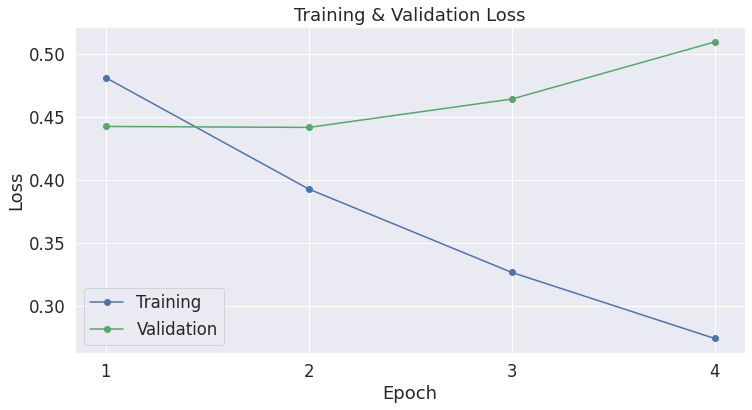

In [319]:
#!g1.1
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
#!g1.1

#сохраним веса модели:

torch.save(model.state_dict(), 'ru-inappropriate.bin')

In [361]:
#!g1.1
device

device(type='cuda')

In [ ]:
#!g1.1



#загрузим модель

#model = TheModelClass(args, *kwargs) 
model.load_state_dict(torch.load('ru-inappropriate.bin')) 
model.to(device)

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [406]:
#!g1.1
test_df.head(2)

,text,inappropriate,offline_crime,online_crime,drugs,gambling,pornography,prostitution,slavery,suicide,...,body_shaming,health_shaming,politics,racism,religion,sexual_minorities,sexism,social_injustice,human_labeled,labels
0,"если тупой, то хотя бы проверь, насколько ты у...",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,1
1,Из за этого началась война между террористоми ...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [407]:
#!g1.1

#!g1.1
import pandas as pd

# Load the dataset into a pandas dataframe.

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_df.shape[0]))

# Create sentence and label lists
sentences = test_df.text.values
labels = (test_df.inappropriate > 0.5).astype('int').values


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.  # max lenght IS SET TO 64!
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 144    #BATCH SIZE!

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 16,334



/home/jupyter/.local/lib/python3.7/site-packages/transformers/tokenization_utils_base.py:2227: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [408]:
#!g1.1
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids, 
                     token_type_ids=None, 
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 16,334 test sentences...
    DONE.


In [409]:
#!g1.1
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)




In [410]:
#!g1.1

flat_true_labels.shape, flat_predictions.shape

((16334,), (16334,))

In [357]:
#!g1.1
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report


## Результаты обучения на deep pavlov

#!g1.1
пример без fine-tuning

In [411]:
#!g1.1

#!g1.1
print('accuracy', np.round(accuracy_score(flat_true_labels, flat_predictions),3)) #качество на тесте
print('f1', np.round(f1_score(flat_true_labels, flat_predictions, average='macro'),2)) #качество на тесте
print('roc_auc', np.round(roc_auc_score(flat_true_labels, np.concatenate(predictions, axis=0)[:, 1]),2)) #качество на тесте

accuracy 0.799
f1 0.75
roc_auc 0.85


In [ ]:
#!g1.1

#!g1.1
print('accuracy', np.round(accuracy_score(flat_true_labels, flat_predictions),3)) #качество на тесте
print('f1', np.round(f1_score(flat_true_labels, flat_predictions, average='macro'),2)) #качество на тесте
print('roc_auc', np.round(roc_auc_score(flat_true_labels, np.concatenate(predictions, axis=0)[:, 1]),2)) #качество на тесте

In [380]:
#!g1.1

#!g1.1
print('accuracy', np.round(accuracy_score(flat_true_labels, flat_predictions),3)) #качество на тесте
print('f1', np.round(f1_score(flat_true_labels, flat_predictions, average='macro'),2)) #качество на тесте
print('roc_auc', np.round(roc_auc_score(flat_true_labels, np.concatenate(predictions, axis=0)[:, 1]),2)) #качество на тесте

accuracy 0.799
f1 0.75
roc_auc 0.85


In [ ]:
#!g1.1
print('roc_auc', np.round(roc_auc_score(y_true, np.concatenate(predictions, axis=0)[:, 1]),2)) #качество на тесте

In [ ]:
#!g1.1

#!g1.1
print('accuracy', np.round(accuracy_score(flat_true_labels, flat_predictions),3)) #качество на тесте
print('f1', np.round(f1_score(flat_true_labels, flat_predictions, average='macro'),2)) #качество на тесте


In [ ]:
#!g1.1


In [272]:
#!g1.1
#!g1.1
print('accuracy', np.round(accuracy_score(y_true, flat_predictions),3)) #качество на тесте
print('f1', np.round(f1_score(y_true, flat_predictions, average='macro'),2)) #качество на тесте
print('roc_auc', np.round(roc_auc_score(y_true, np.concatenate(predictions, axis=0)[:, 1]),2)) #качество на тесте

accuracy 0.789
f1 0.74
roc_auc 0.84


In [327]:
#!g1.1
#!g1.1
print(classification_report(flat_true_labels, flat_predictions)) #качество на тесте

              precision    recall  f1-score   support

           0       0.84      0.86      0.85     11442
           1       0.66      0.61      0.63      4892

    accuracy                           0.79     16334
   macro avg       0.75      0.74      0.74     16334
weighted avg       0.79      0.79      0.79     16334



In [381]:
#!g1.1
print(classification_report(y_true, flat_predictions)) #качество на тесте


              precision    recall  f1-score   support

           0       0.83      0.89      0.86     11442
           1       0.70      0.59      0.64      4892

    accuracy                           0.80     16334
   macro avg       0.76      0.74      0.75     16334
weighted avg       0.79      0.80      0.79     16334



## Сравним с результатами мультиязычной модели

In [292]:
#!g1.1
#!g1.1
print('accuracy', np.round(accuracy_score(y_true, flat_predictions),3)) #качество на тесте
print('f1', np.round(f1_score(y_true, flat_predictions, average='macro'),2)) #качество на тесте
print('roc_auc', np.round(roc_auc_score(y_true, np.concatenate(predictions, axis=0)[:, 1]),2)) #качество на тесте

accuracy 0.781
f1 0.72
roc_auc 0.83


In [294]:
#!g1.1
print(classification_report(y_true, flat_predictions)) #качество на тесте


              precision    recall  f1-score   support

           0       0.82      0.88      0.85     11442
           1       0.66      0.55      0.60      4892

    accuracy                           0.78     16334
   macro avg       0.74      0.71      0.72     16334
weighted avg       0.77      0.78      0.77     16334



In [ ]:
## Вывод

мы обучили две модели на одном русскоязычном датасете для бинарной классификации

Мы видим, что моноязычная модель "из коробки" работает чуть лучше, чем мультиязычная модель. 
Насколько важна разница в несколько пунктов - зависит от задачи, тем не менее, стоит так же провести сравнение с моделью с полным мультиязычным словарем и 
сравнить результат 


Предметом нашего исследования является - поиск - есть ли разница в уязвимости моделей для адверсариальных атак в
зависимости от того, модель моно или мультиязычная

## Adversarial

In [413]:
#!g1.1
from textattack.transformations import WordSwapEmbedding



In [ ]:
#!g1.1

from textattack.shared import AbstractWordEmbedding, WordEmbedding

In [420]:
#!g1.1
1+1

2

In [421]:
#!g1.1
from textattack.shared.word_embeddings.py import GensimWordEmbedding

ModuleNotFoundError: No module named 'textattack.shared.word_embeddings.py'; 'textattack.shared.word_embeddings' is not a package

In [417]:
#!g1.1
# попробуем переписать textfooler

# GensimWordEmbedding

from textattack import Attack
from textattack.constraints.grammaticality import PartOfSpeech
from textattack.constraints.pre_transformation import (
    InputColumnModification,
    RepeatModification,
    StopwordModification,
)
from textattack.constraints.semantics import WordEmbeddingDistance
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder
from textattack.goal_functions import UntargetedClassification
from textattack.search_methods import GreedyWordSwapWIR
from textattack.transformations import WordSwapEmbedding

from textattack.attack_recipes.attack_recipe import AttackRecipe


class TextFooler2021Ru(AttackRecipe):

    @staticmethod
    def build(model_wrapper):
        #
        # Swap words with their 50 closest embedding nearest-neighbors.
        # Embedding: Counter-fitted PARAGRAM-SL999 vectors.
        #
        transformation = WordSwapEmbedding(embedding = GensimWordEmbedding, max_candidates=50)
        #
        # Don't modify the same word twice or the stopwords defined
        # in the TextFooler public implementation.
        #
        # fmt: off
        stopwords = set(
            ['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 
             'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 
             'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда',
             'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 
             'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей',
             'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 
             'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 
             'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 
             'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда',
             'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через',
             'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впрочем', 
             'хорошо', 'свою', 'этой', 'перед', 'иногда', 'лучше', 'чуть', 'том', 'нельзя', 'такой', 'им', 'более', 'всегда', 'конечно', 'всю', 'между']
        )
        # fmt: on
        constraints = [RepeatModification(), StopwordModification(stopwords=stopwords)]
        #
        # During entailment, we should only edit the hypothesis - keep the premise
        # the same.
        #
        input_column_modification = InputColumnModification(
            ["premise", "hypothesis"], {"premise"}
        )
        constraints.append(input_column_modification)
        # Minimum word embedding cosine similarity of 0.5.
        # (The paper claims 0.7, but analysis of the released code and some empirical
        # results show that it's 0.5.)
        #
        constraints.append(WordEmbeddingDistance(min_cos_sim=0.5))
        #
        # Only replace words with the same part of speech (or nouns with verbs)
        #
        constraints.append(PartOfSpeech(allow_verb_noun_swap=True))
        #
        # Universal Sentence Encoder with a minimum angular similarity of ε = 0.5.
        #
        # In the TextFooler code, they forget to divide the angle between the two
        # embeddings by pi. So if the original threshold was that 1 - sim >= 0.5, the
        # new threshold is 1 - (0.5) / pi = 0.840845057
        #
        use_constraint = UniversalSentenceEncoder(
            threshold=0.840845057,
            metric="angular",
            compare_against_original=False,
            window_size=15,
            skip_text_shorter_than_window=True,
        )
        constraints.append(use_constraint)
        #
        # Goal is untargeted classification
        #
        goal_function = UntargetedClassification(model_wrapper)
        #
        # Greedily swap words with "Word Importance Ranking".
        #
        search_method = GreedyWordSwapWIR(wir_method="delete")

        return Attack(goal_function, constraints, transformation, search_method)

In [418]:
#!g1.1
TextFooler2021Ru.

__main__.TextFooler2021Ru

In [419]:
#!g1.1
attack = TextFooler2021Ru.build(model_wrapper)

NameError: name 'GensimWordEmbedding' is not defined

In [ ]:
#!g1.1
model_wrapper

In [ ]:
#!g1.1
Главное - чтобы атаки заработали для русского языка!

In [382]:
#!g1.1

# обернем атаку

import textattack
from datasets import Dataset


model_wrapper = textattack.models.wrappers.HuggingFaceModelWrapper(model, tokenizer)
attack = textattack.attack_recipes.PWWSRen2019.build(model_wrapper)

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


In [399]:
#!g1.1
attack.transformation.language = "rus"


In [383]:
#!g1.1
test_df['labels'] = (test_df.inappropriate > 0.5).astype('int').values

dataset = Dataset.from_pandas(test_df.sample(1000)[['text', 'labels']])

dataset = textattack.datasets.HuggingFaceDataset(dataset, dataset_columns = (['text'], 'labels'))


In [398]:
#!g1.1
print(test_df[test_df.text.str.contains('АЙФОН')].text.values)

['скажи свое имя NUMBER раз попей воды поползай под столом и под твоей подушкой будет АЙФОН а там твой номер']


In [400]:
#!g1.1
attack_args = textattack.AttackArgs(num_examples=100, log_to_csv="logRu11.csv", checkpoint_interval=20, checkpoint_dir="checkpoints", disable_stdout=True)


In [401]:
#!g1.1
#!g1.1
attacker = textattack.Attacker(attack, dataset, attack_args)


# что на вход можно подавать в качестве аргумента для датасета? туториал подсказывает, что нужно сначала загрузить датасет в библиотеку

In [ ]:
#!g1.1

#!g1.1
%%time 

attacker.attack_dataset()

In [ ]:
#!g1.1
вместо атак для русского языка - мультиязычные?

In [ ]:
#!g1.1

#попробуем PWWSRen2019 рецепт
# Create the recipe: PWWS uses a WordNet transformation.
recipe = PWWSRen2019.build(model_wrapper)
#
# WordNet defaults to english. Set the default language to French ('fra')
#
# See "Building a free French wordnet from multilingual resources",
# E. L. R. A. (ELRA) (ed.),
# Proceedings of the Sixth International Language Resources and Evaluation (LREC’08).
recipe.transformation.language = 'rus'


attacker.attack_dataset()

In [402]:
#!g1.1
%%time 

attacker.attack_dataset()

Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapEmbedding(
    (max_candidates):  50
    (embedding):  WordEmbedding
  )
  (constraints): 
    (0): WordEmbeddingDistance(
        (embedding):  WordEmbedding
        (min_cos_sim):  0.5
        (cased):  False
        (include_unknown_words):  True
        (compare_against_original):  True
      )
    (1): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (2): UniversalSentenceEncoder(
        (metric):  angular
        (threshold):  0.840845057
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  False
      )
    (3): RepeatModification
    (4): StopwordModification
    (5): InputColumnModification(
        (matching_column_labels):  ['premise', 'hypothesis']
       

textattack: Logging to CSV at path logRu11.csv
[Succeeded / Failed / Skipped / Total] 2 / 15 / 3 / 20:  20%|██        | 20/100 [00:07<00:30,  2.64it/s]textattack: Saving checkpoint under "checkpoints/1640548459003.ta.chkpt" at 2021-12-26 19:54:19 after 20 attacks.
[Succeeded / Failed / Skipped / Total] 3 / 30 / 7 / 40:  40%|████      | 40/100 [00:13<00:20,  2.92it/s]textattack: Saving checkpoint under "checkpoints/1640548465111.ta.chkpt" at 2021-12-26 19:54:25 after 40 attacks.
[Succeeded / Failed / Skipped / Total] 3 / 42 / 15 / 60:  60%|██████    | 60/100 [00:17<00:11,  3.47it/s]textattack: Saving checkpoint under "checkpoints/1640548468721.ta.chkpt" at 2021-12-26 19:54:28 after 60 attacks.
[Succeeded / Failed / Skipped / Total] 4 / 56 / 20 / 80:  80%|████████  | 80/100 [00:24<00:06,  3.32it/s]textattack: Saving checkpoint under "checkpoints/1640548475497.ta.chkpt" at 2021-12-26 19:54:35 after 80 attacks.
[Succeeded / Failed / Skipped / Total] 7 / 70 / 23 / 100: 100%|██████████| 100/

In [ ]:
#!g1.1
%%time 

attacker.attack_dataset()

In [ ]:
#!g1.1
Как мы видим - есть большая волатильность результатов атак и модели в зависимости от разбиения

In [ ]:
#!g1.1
что мы сделали - взяли дообученную модель Берта для классификации
модель - моноязычная (русская)
текст - русский
атака - textfooler

результат - 

как адаптировать textfooler  на русский - RusVectors?

In [ ]:
#!g1.1
пришло время понять -как адаптировать рецепт под русский язык!

#!g1.1
## Все вместе:

In [336]:
#!g1.1
%%time

#!g1.1
## Попробуем BAE еще раз
#attack_recipes.bae_garg_2019.BAEGarg2019
attack = textattack.attack_recipes.bae_garg_2019.BAEGarg2019.build(model_wrapper)
attack_args = textattack.AttackArgs(num_examples=100, log_to_csv="logRu2.csv", checkpoint_interval=20, checkpoint_dir="checkpoints", disable_stdout=True)
attacker = textattack.Attacker(attack, dataset, attack_args)
attacker.attack_dataset()






Attack(
  (search_method): GreedyWordSwapWIR(
    (wir_method):  delete
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.936338023
        (window_size):  15
        (skip_text_shorter_than_window):  True
        (compare_against_original):  True
      )
    (2): RepeatModification
    (3): StopwordModification
  (is_black_box):  True
) 

















+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 52     |
| Number of faile

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Logging to CSV at path logRu2.csv
[Succeeded / Failed / Skipped / Total] 11 / 1 / 8 / 20:  20%|██        

In [ ]:
#!g1.1
с учетом того, что у моделей разные словари - нужно понять, как адаптировать для русского?
посмотреть примеры для других языков из репозитория

In [ ]:
#!g1.1
Пока что видно, что бае справляется - нужно смотреть на примеры